In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import uproot
import astropy.io.fits as fits

from scipy import stats
from sklearn import metrics

### Lee el archivo CSV

In [2]:
catalog = pd.read_csv('./datos_csv/1.root.csv', index_col=0)
ccd_count = pd.DataFrame({'count': catalog.index.value_counts().sort_index()})
ccd_count.index.name = 'eventNumber'
freq = ccd_count.value_counts().sort_index()
ccd_count_max = ccd_count[ccd_count['count'] == freq.index[-1][0]]

### Entrena los regresores lineales

In [3]:
ccd_1 = catalog[catalog['muonCCD'] == 1].drop('muonCCD', axis=1)
ccd_2 = catalog[catalog['muonCCD'] == 2].drop('muonCCD', axis=1)
ccd_1_2 = ccd_1.join(ccd_2, how='inner', lsuffix='_CCD1', rsuffix='_CCD2')
ccd_1_2['distX'] = ccd_1_2['centerX_CCD2'] - ccd_1_2['centerX_CCD1']
ccd_1_2['distY'] = ccd_1_2['centerY_CCD2'] - ccd_1_2['centerY_CCD1']

ccd_1_2

,centerX_CCD1,centerY_CCD1,sizeX_CCD1,sizeY_CCD1,asymX_CCD1,asymY_CCD1,centerX_CCD2,centerY_CCD2,sizeX_CCD2,sizeY_CCD2,asymX_CCD2,asymY_CCD2,distX,distY
eventNumber,,,,,,,,,,,,,,
15,-3701.897342,22563.553721,207.537701,212.857987,-31.277569,-32.923240,-2687.238579,23592.070934,207.771342,210.981421,-29.819193,-31.938544,1014.658763,1028.517213
3337,-14469.547722,-31236.333861,156.780626,126.561988,-33.802897,5.992886,-13934.352420,-31260.533978,141.316554,153.860588,-29.986969,11.767690,535.195303,-24.200117
3329,-5046.802374,5690.118066,305.096291,222.780240,28.240876,-28.144576,-6817.758909,6828.853831,304.470267,221.664098,32.159730,-30.925078,-1770.956535,1138.735765
3326,5549.341594,-9806.188557,130.048023,134.435952,-22.295212,11.608392,5854.014393,-10032.210390,143.266383,130.453229,-20.070990,18.682095,304.672799,-226.021832
3314,2097.648522,-11652.124825,312.941495,145.603145,30.056139,27.051341,270.498346,-12227.681613,296.740219,145.250927,21.172743,28.003826,-1827.150175,-575.556788
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1482,2781.325279,5399.910630,153.154802,333.940708,-28.023122,-30.778890,3373.856384,7360.837754,144.267678,305.723046,-21.513824,-19.525251,592.531105,1960.927124
1554,2091.926816,4466.318603,239.723850,138.690015,-28.213404,-19.709787,3378.875420,4829.916267,240.985781,147.277982,-30.714231,-22.400660,1286.948604,363.597664
1568,3712.062760,-277.066264,129.909688,238.401702,14.019174,26.639085,3477.689700,-1623.652762,132.265039,244.441837,13.320414,29.361551,-234.373060,-1346.586498


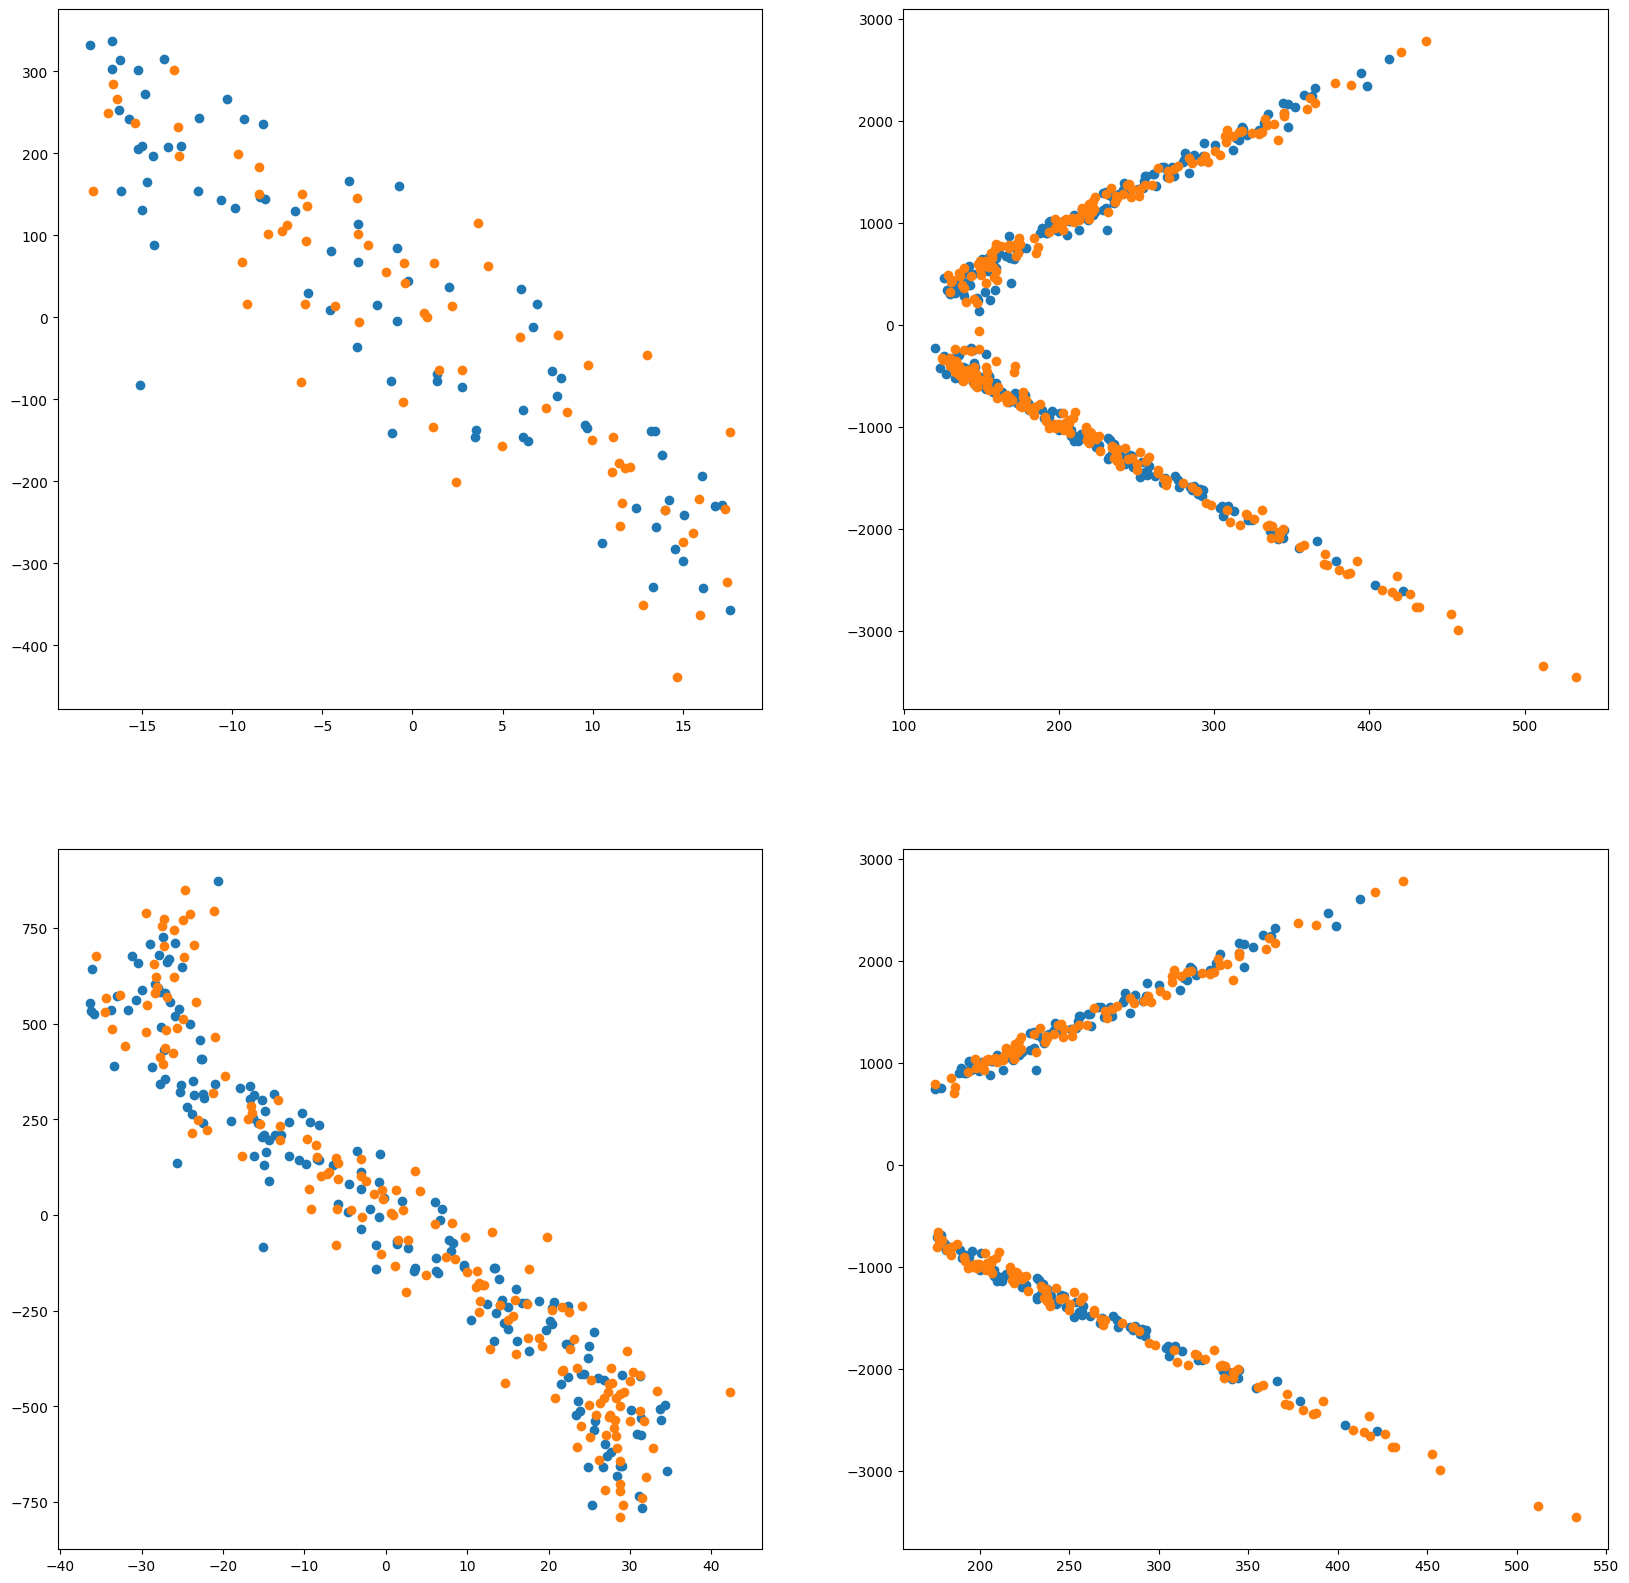

In [4]:
asym_threshold = 18
size_threshold = 175

f, ax = plt.subplots(2, 2, figsize=(20,20))


dist_short = ccd_1_2[np.abs(ccd_1_2['asymX_CCD1']) < asym_threshold]
dist_long = ccd_1_2[np.abs(ccd_1_2['asymX_CCD1']) >= asym_threshold]

ax[0, 0].scatter(dist_short['asymX_CCD1'], dist_short['centerX_CCD2'] - dist_short['centerX_CCD1'])
ax[0, 1].scatter(dist_long['sizeX_CCD1'], dist_long['centerX_CCD2'] - dist_long['centerX_CCD1'])

dist_short = ccd_1_2[np.abs(ccd_1_2['sizeX_CCD1']) < size_threshold]
dist_long = ccd_1_2[np.abs(ccd_1_2['sizeX_CCD1']) >= size_threshold]

ax[1, 0].scatter(dist_short['asymX_CCD1'], dist_short['centerX_CCD2'] - dist_short['centerX_CCD1'])
ax[1, 1].scatter(dist_long['sizeX_CCD1'], dist_long['centerX_CCD2'] - dist_long['centerX_CCD1'])

dist_short = ccd_1_2[np.abs(ccd_1_2['asymY_CCD1']) < asym_threshold]
dist_long = ccd_1_2[np.abs(ccd_1_2['asymY_CCD1']) >= asym_threshold]

ax[0, 0].scatter(dist_short['asymY_CCD1'], dist_short['centerY_CCD2'] - dist_short['centerY_CCD1'])
ax[0, 1].scatter(dist_long['sizeY_CCD1'], dist_long['centerY_CCD2'] - dist_long['centerY_CCD1'])

dist_short = ccd_1_2[np.abs(ccd_1_2['sizeY_CCD1']) < size_threshold]
dist_long = ccd_1_2[np.abs(ccd_1_2['sizeY_CCD1']) >= size_threshold]

ax[1, 0].scatter(dist_short['asymY_CCD1'], dist_short['centerY_CCD2'] - dist_short['centerY_CCD1'])
ax[1, 1].scatter(dist_long['sizeY_CCD1'], dist_long['centerY_CCD2'] - dist_long['centerY_CCD1'])

In [5]:
short_dist_X_mask = np.abs(ccd_1_2['sizeX_CCD1']) < size_threshold
short_dist_Y_mask = np.abs(ccd_1_2['sizeY_CCD1']) < size_threshold

# short_dist_X_mask = np.abs(ccd_1_2['asymX_CCD1']) < asym_threshold
# short_dist_Y_mask = np.abs(ccd_1_2['asymY_CCD1']) < asym_threshold

dist_X_short = ccd_1_2[short_dist_X_mask]
dist_X_long = ccd_1_2[~short_dist_X_mask]

dist_Y_short = ccd_1_2[short_dist_Y_mask]
dist_Y_long = ccd_1_2[~short_dist_Y_mask]

asym_array = pd.concat([dist_X_short['asymX_CCD1'], dist_Y_short['asymY_CCD1']])
short_dist_array = pd.concat([dist_X_short['distX'], dist_Y_short['distY']])

size_array = pd.concat([dist_X_long['sizeX_CCD1'], dist_Y_long['sizeY_CCD1']])
long_dist_array = np.abs(pd.concat([dist_X_long['distX'], dist_Y_long['distY']]))

lr_asym_based = stats.linregress(asym_array, short_dist_array)
lr_size_based = stats.linregress(size_array, long_dist_array)

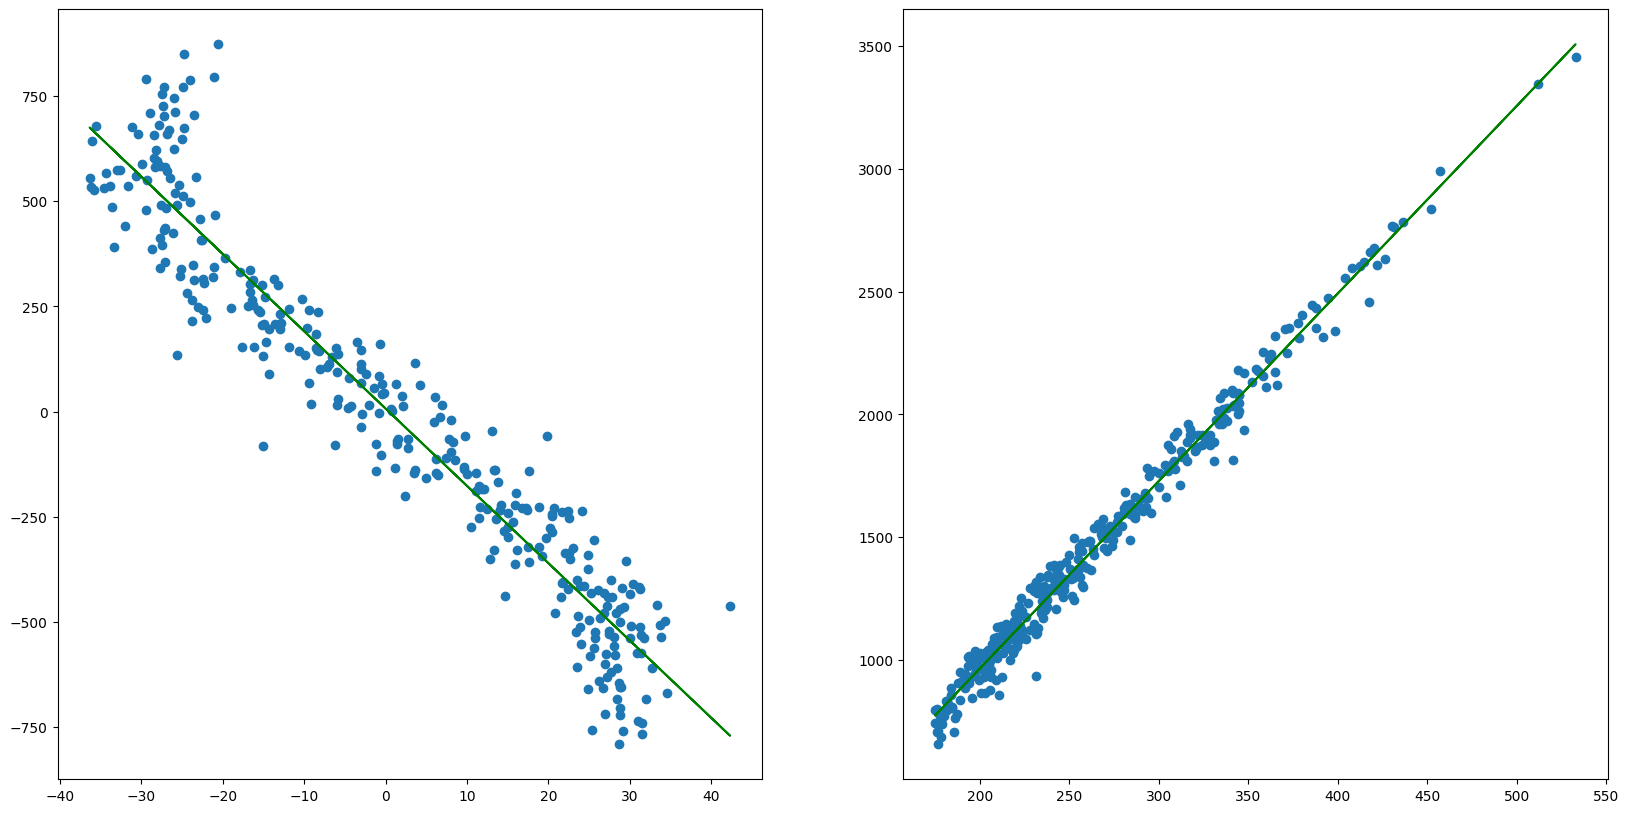

In [6]:
f, ax = plt.subplots(1, 2, figsize=(20,10))
ax[0].scatter(asym_array, short_dist_array)
ax[1].scatter(size_array, long_dist_array)
ax[0].plot(asym_array, asym_array*lr_asym_based.slope+lr_asym_based.intercept, color='green')
ax[1].plot(size_array, size_array*lr_size_based.slope+lr_size_based.intercept, color='green')

### Prepara el catálogo etiquetado y el no etiquetado

In [7]:
labeled_catalog = catalog.reset_index()
labeled_catalog

,eventNumber,muonCCD,centerX,centerY,sizeX,sizeY,asymX,asymY
0,15,1,-3701.897342,22563.553721,207.537701,212.857987,-31.277569,-32.923240
1,3337,1,-14469.547722,-31236.333861,156.780626,126.561988,-33.802897,5.992886
2,3329,1,-5046.802374,5690.118066,305.096291,222.780240,28.240876,-28.144576
3,3326,1,5549.341594,-9806.188557,130.048023,134.435952,-22.295212,11.608392
4,3314,1,2097.648522,-11652.124825,312.941495,145.603145,30.056139,27.051341
...,...,...,...,...,...,...,...,...
2697,1568,10,1614.202784,-12437.717876,144.659781,274.466620,18.904786,43.530928
2698,1589,10,4066.571850,-12290.154452,119.173413,128.597600,22.954914,6.806634
2699,1598,10,-7683.928037,12937.357679,129.763422,143.874409,-18.488772,21.453253
2700,1344,10,-8334.694629,2588.626382,176.339106,209.644697,-3.043877,-27.110330


In [8]:
unlabeled_catalog = labeled_catalog.copy()
unlabeled_catalog['eventNumber'] = 0
unlabeled_catalog

,eventNumber,muonCCD,centerX,centerY,sizeX,sizeY,asymX,asymY
0,0,1,-3701.897342,22563.553721,207.537701,212.857987,-31.277569,-32.923240
1,0,1,-14469.547722,-31236.333861,156.780626,126.561988,-33.802897,5.992886
2,0,1,-5046.802374,5690.118066,305.096291,222.780240,28.240876,-28.144576
3,0,1,5549.341594,-9806.188557,130.048023,134.435952,-22.295212,11.608392
4,0,1,2097.648522,-11652.124825,312.941495,145.603145,30.056139,27.051341
...,...,...,...,...,...,...,...,...
2697,0,10,1614.202784,-12437.717876,144.659781,274.466620,18.904786,43.530928
2698,0,10,4066.571850,-12290.154452,119.173413,128.597600,22.954914,6.806634
2699,0,10,-7683.928037,12937.357679,129.763422,143.874409,-18.488772,21.453253
2700,0,10,-8334.694629,2588.626382,176.339106,209.644697,-3.043877,-27.110330


### Predice la trayectoria de una partícula a partir de un impacto

In [9]:
lr_asym_based

LinregressResult(slope=-18.36780106286494, intercept=6.881996494657642, rvalue=-0.9570313104871051, pvalue=2.5013901153083297e-177, stderr=0.30824579565079746, intercept_stderr=6.678225943257691)

In [10]:
lr_size_based

LinregressResult(slope=7.641878584145551, intercept=-564.8448915083077, rvalue=0.9926894320947556, pvalue=0.0, stderr=0.04924442856833355, intercept_stderr=13.482308709039716)

In [11]:
unlabeled_catalog = labeled_catalog.copy()
unlabeled_catalog['eventNumber'] = 0

model = {
    'lr_short': lr_asym_based,
    'lr_long': lr_size_based,
    'asym_threshold': 18,
    'size_threshold': 175,
    'size_var': 200,
    'error_range': 500,
    'width_trace': 200,
    'events_found': 0,
    'tracks_predict': {},
}



def best_match(row, pred, model):
    
    if len(pred.index) < 2:
        return pred
    
    sizeX = row['sizeX']
    sizeY = row['sizeY']
    
    asymX = row['asymX']
    asymY = row['asymY']

    pred = pred.assign(size_diff = (pred['sizeX'] - sizeX)**2 + (pred['sizeY'] - sizeY)**2)
    pred = pred.assign(asym_diff = (pred['asymX'] - asymX)**2 + (pred['asymY'] - asymY)**2)
    pred = pred.assign(sort_metric = pred['size_diff'] + pred['asym_diff'])
    
    return pred.sort_values('sort_metric').drop(['size_diff', 'asym_diff', 'sort_metric'], axis=1).iloc[[0]]


def filter_predictions(df, row, model):
            
    error = model['error_range']
    size_var = model['size_var']
    
    if row['sizeX'] < model['size_threshold']:
#     if row['asymX'] < model['asym_threshold']:
        est_x = row['asymX']*model['lr_short'].slope + model['lr_short'].intercept
    else:
        est_x = row['sizeX']*model['lr_long'].slope + model['lr_long'].intercept
        if row['asymX'] > 0:
            est_x = -est_x

    if row['sizeY'] < model['size_threshold']:
#     if row['asymY'] < model['asym_threshold']:
        est_y = row['asymY']*model['lr_short'].slope + model['lr_short'].intercept
    else:
        est_y = row['sizeY']*model['lr_long'].slope + model['lr_long'].intercept
        if row['asymY'] > 0:
            est_y = -est_y
    
    est_x += row['centerX']
    est_y += row['centerY']

    prediction = df[(df['muonCCD'] == row['muonCCD']+1) & (
        ((est_x - error) < df['centerX']) & (df['centerX'] < (est_x + error))
    ) & (
        ((est_y - error) < df['centerY']) & (df['centerY'] < (est_y + error))
    ) & (
        ((row['sizeX'] - size_var) < df['sizeX']) & (df['sizeX'] < (row['sizeX'] + size_var))
    ) & (
        ((row['sizeY'] - size_var) < df['sizeY']) & (df['sizeY'] < (row['sizeY'] + size_var))
    )]
    
    prediction = prediction[prediction['eventNumber'] == 0]
    return prediction



def trace_path(df, point_a, point_b, model):
    
    error = model['width_trace']
    size_var = model['size_var']
    
    sizeX = point_b['sizeX']
    sizeY = point_b['sizeY']

    est_x = point_b['centerX'] + (point_b['centerX'] - point_a['centerX'])
    est_y = point_b['centerY'] + (point_b['centerY'] - point_a['centerY'])

    prediction = df[(df['muonCCD'] == point_b['muonCCD']+1) & (
        ((est_x - error) < df['centerX']) & (df['centerX'] < (est_x + error))
    ) & (
        ((est_y - error) < df['centerY']) & (df['centerY'] < (est_y + error))
    ) & (
        ((point_b['sizeX'] - size_var) < df['sizeX']) & (df['sizeX'] < (point_b['sizeX'] + size_var))
    ) & (
        ((point_b['sizeY'] - size_var) < df['sizeY']) & (df['sizeY'] < (point_b['sizeY'] + size_var))
    )]
    
    prediction = prediction[prediction['eventNumber'] == 0]
    return prediction



def follow_path(df, point_a, point_b, model, path):
    
    if point_b['muonCCD'] == 10:
        #print(path)
        model['tracks_predict'][model['events_found']] = list(path)
        model['events_found'] += 1
        df.loc[path, 'eventNumber'] = model['events_found']
        return
    
    pred = trace_path(df, point_a, point_b, model)
    pred = best_match(point_b, pred, model)
    
    if pred.shape[0] == 0:
        #print(path)
        model['tracks_predict'][model['events_found']] = list(path)
        model['events_found'] += 1
        df.loc[path, 'eventNumber'] = model['events_found']
        return
    
    pred = pred.sample(1)
    for i, point_c in pred.iterrows():   
        path.append(i)
        follow_path(df, point_b, point_c, model, path)
        path.pop()
        break



for i in range(len(unlabeled_catalog)):
    
    row = unlabeled_catalog.iloc[i]
    
    if row['eventNumber'] != 0:
        continue
    
    #print(model['events_found'], '\t', end='')
    
    path = [i]
    pred = filter_predictions(unlabeled_catalog, row, model)
    pred = best_match(row, pred, model)
    
    if pred.shape[0] == 0:
        #print(path)
        model['tracks_predict'][model['events_found']] = list(path)
        model['events_found'] += 1
        unlabeled_catalog.loc[path, 'eventNumber'] = model['events_found']
        continue
    
    pred = pred.sample(1)
    for j, point in pred.iterrows():
        path.append(j)
        follow_path(unlabeled_catalog, row, point, model, path)
        path.pop()
        break

tracks_predict = model['tracks_predict']

In [12]:
event_numbers = set()

tracks_truth = {}
events_found = 0

for i, row in labeled_catalog.iterrows():
    
    event = row['eventNumber']
    
    if event in event_numbers:
        continue
    
    event_numbers.add(event)
    path = labeled_catalog[labeled_catalog['eventNumber'] == event].index.array
    tracks_truth[events_found] = list(path)
    #print(events_found, '\t', list(path))
    events_found += 1

### Evalúa el desempeño del algoritmo

In [13]:
metrics.adjusted_mutual_info_score(labeled_catalog['eventNumber'], unlabeled_catalog['eventNumber'])

0.99945387414224

In [14]:
diff_tracks = {}

for i in range(np.max([len(tracks_predict), len(tracks_truth)])):
    
    if i < len(tracks_truth) and i < len(tracks_predict):
    
        # tracks iguales
        if tracks_truth[i] == tracks_predict[i]:
            #print(i, '\t', tracks_truth[i])
            pass
    
        # tracks diferentes
        else:
#             if tracks_truth[i][0] != tracks_predict[i][0]:
#                 break
            
            diff_tracks[i] = (tracks_truth[i], tracks_predict[i])
    
    else:
        if i < len(tracks_predict):
            diff_tracks[i] = ([], tracks_predict[i])
            
        elif i < len(tracks_truth):
            diff_tracks[i] = (tracks_truth[i], [])
            

for i, (real_track, pred_track) in diff_tracks.items():        
    print(i, '\t', real_track)
    print(i, '\t', pred_track)
    print()

9 	 [9]
9 	 [9, 622]

267 	 [267, 622]
267 	 [267]

337 	 [337, 695, 1013, 1314, 1584, 1833, 2074, 2301, 2502, 2686]
337 	 [337, 695, 1013, 1314, 1584, 1833, 2074, 2301, 2502]

398 	 []
398 	 [2686]



In [15]:
unlabeled_catalog

,eventNumber,muonCCD,centerX,centerY,sizeX,sizeY,asymX,asymY
0,1,1,-3701.897342,22563.553721,207.537701,212.857987,-31.277569,-32.923240
1,2,1,-14469.547722,-31236.333861,156.780626,126.561988,-33.802897,5.992886
2,3,1,-5046.802374,5690.118066,305.096291,222.780240,28.240876,-28.144576
3,4,1,5549.341594,-9806.188557,130.048023,134.435952,-22.295212,11.608392
4,5,1,2097.648522,-11652.124825,312.941495,145.603145,30.056139,27.051341
...,...,...,...,...,...,...,...,...
2697,367,10,1614.202784,-12437.717876,144.659781,274.466620,18.904786,43.530928
2698,360,10,4066.571850,-12290.154452,119.173413,128.597600,22.954914,6.806634
2699,361,10,-7683.928037,12937.357679,129.763422,143.874409,-18.488772,21.453253
2700,332,10,-8334.694629,2588.626382,176.339106,209.644697,-3.043877,-27.110330


[337, 695, 1013, 1314, 1584, 1833, 2074, 2301, 2502, 2686]
[337, 695, 1013, 1314, 1584, 1833, 2074, 2301, 2502]


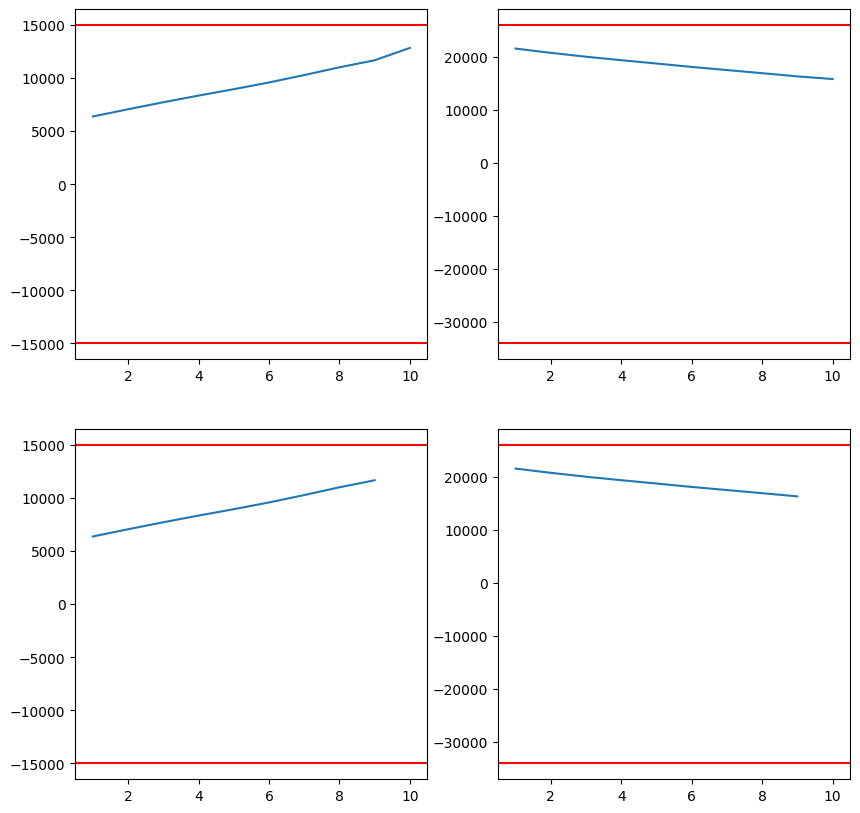

In [16]:
i = 337

f, ax = plt.subplots(2, 2, figsize=(10, 10))


for j, tracks in enumerate([tracks_truth, tracks_predict]):

    traj = labeled_catalog.loc[tracks[i]].set_index('muonCCD')
    
    print(tracks[i])
    
    ax[j,0].axhline(15000, color='red')
    ax[j,0].axhline(-15000, color='red')
    
    ax[j,1].axhline(26000, color='red')
    ax[j,1].axhline(-34000, color='red')
    
    ax[j,0].plot(traj['centerX'])
    ax[j,1].plot(traj['centerY'])
    ax[j,0].set_xlim([0.5, 10.5])
    ax[j,1].set_xlim([0.5, 10.5])

In [17]:
df = labeled_catalog.loc[[337, 695, 1013, 1314, 1584, 1833, 2074, 2301, 2502, 2686]]

centerX = df.iloc[0]['centerX']
centerY = df.iloc[0]['centerY']

sizeX = df.iloc[0]['sizeX']
sizeY = df.iloc[0]['sizeY']

asymX = df.iloc[0]['asymX']
asymY = df.iloc[0]['asymY']

# df = df.assign(size_diff = np.sqrt((df['sizeX'] - sizeX)**2 + (df['sizeY'] - sizeY)**2))
# df = df.assign(asym_diff = np.sqrt((df['asymX'] - asymX)**2 + (df['asymY'] - asymY)**2))
# df = df.assign(centerX_diff = df['centerX'] - centerX)
# df = df.assign(centerY_diff = df['centerY'] - centerY)
# df = df.assign(sizeX_diff = df['sizeX'] - sizeX)
# df = df.assign(sizeY_diff = df['sizeY'] - sizeY)
df

,eventNumber,muonCCD,centerX,centerY,sizeX,sizeY,asymX,asymY
337,1278,1,6392.782964,21588.885396,166.487674,176.333934,-27.823081,27.840339
695,1278,2,7072.780121,20788.457127,164.069597,169.082260,-29.645733,25.022459
1013,1278,3,7732.187569,20056.758363,151.732635,164.966789,-28.943381,34.385363
1314,1278,4,8362.514040,19398.465539,163.013655,152.758361,-30.433772,25.152518
1584,1278,5,8964.097029,18771.090365,149.656095,157.992508,-28.771275,30.149814
1833,1278,6,9600.298902,18127.974217,158.948897,148.950310,-29.446518,27.012893
2074,1278,7,10296.904722,17538.717455,170.849944,159.107532,-29.834700,32.608157
2301,1278,8,11029.485298,16950.275869,151.627643,184.134686,-25.395975,42.717654
2502,1278,9,11691.961993,16347.118365,203.088165,157.944007,-39.400442,32.887177
2686,1278,10,12856.662244,15845.874224,239.116086,147.183778,-36.391584,26.467441


In [18]:
df = labeled_catalog.loc[[9, 267, 622]]

centerX = df.iloc[0]['centerX']
centerY = df.iloc[0]['centerY']

sizeX = df.iloc[0]['sizeX']
sizeY = df.iloc[0]['sizeY']

asymX = df.iloc[0]['asymX']
asymY = df.iloc[0]['asymY']

# df = df.assign(size_diff = np.sqrt((df['sizeX'] - sizeX)**2 + (df['sizeY'] - sizeY)**2))
# df = df.assign(asym_diff = np.sqrt((df['asymX'] - asymX)**2 + (df['asymY'] - asymY)**2))
# df = df.assign(centerX_diff = df['centerX'] - centerX)
# df = df.assign(centerY_diff = df['centerY'] - centerY)
# df = df.assign(sizeX_diff = df['sizeX'] - sizeX)
# df = df.assign(sizeY_diff = df['sizeY'] - sizeY)
df

,eventNumber,muonCCD,centerX,centerY,sizeX,sizeY,asymX,asymY
9,3270,1,375.880589,-31783.183351,268.938048,342.703826,32.548390,35.633324
267,445,1,262.052801,-32726.727029,243.186746,169.840067,28.111370,31.460207
622,445,2,-1092.700699,-33466.294602,259.942139,164.837864,34.861488,25.077754


In [19]:
def microns_to_pixels(pos_x, pos_y):
    return (pos_y + 34000) * (4096 / 60000), (pos_x + 15000) * (2048 / 30000)

microns_to_pixels(10128, 25992)

(4095.4538666666667, 1715.4048)